# Learning goals
After this week's lesson you should be able to:
- Perform an overlay analysis
- Reclassify data
- Perform a spatial join (Refresher)

This week's lessons are adapted from:
- [Automating GIS Processes Lesson 3](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-3/overview.html)
- [Automating GIS Processes Lesson 4](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-4/overview.html)

In [1]:
# We are going to start importing the libraries we need
# all in one cell. 
# It is a good practice to keep all the imports in one cell so that
# we can easily see what libraries we are using in the notebook.
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt

os.getcwd()

/var/folders/c5/dps3lj6n2sz8zkk_381lj9b1hnpv4f/T/ipykernel_21643/1246542324.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


'/Users/pbb62/Library/CloudStorage/OneDrive-CornellUniversity/Coding-Assignments/4680_5680_intro_uds_pb/Week3'

# 1. Overlay Analysis
Overlay analyses are GIS operations in which two or more vector layers are combined to produce new geometries. Typical overlay operations include union, intersection, and difference - named after the result of the combination of two layers.

</figure>
<img src="https://autogis-site.readthedocs.io/en/latest/_images/overlay-operations_700x200px.svg" alt="drawing" width="700" style="display: block; margin: 0 auto"/>
</figure>

## 1.1 Loading data
Let's say we wanted to study which [neighborhoods](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz) in NYC are more vulnerable to flooding. Here, we will measure vulnerability as the areal coverage of the neighborhood by the [NYC Stormwater Flood Map](https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Moderate-Flood-with-2050-/5rzh-cyqd). 

Let's download two datasets and put it into our current folder: 
- The [Neighborhood Tabulation Areas](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz) (make sure to download the shapefile)
- [NYC Stormwater Flood Map - Moderate Flood with 2050 Sea Level Rise](https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Moderate-Flood-with-2050-/5rzh-cyqd) There is a zip file in on this page and you will have to unzip to read a `.gdb` file

In [2]:
nta = gpd.read_file('NTA map.zip')

In [3]:
nta.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700..."
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861..."
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651..."


<AxesSubplot: >

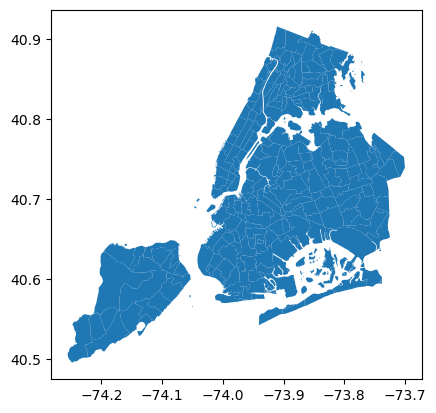

In [4]:
nta.plot()

In [5]:
## I'm sorry this file is a pain 
## It is a .gdb file, which is a geodatabase file in ArcGIS
## It only has one layer, so we can just read it in with layer=0
## We can also use the driver='FileGDB' to tell geopandas that it is a geodatabase file
## Though Geopandas will infer the file format from the file extension, so we don't need to specify the driver 



flood_2050 = gpd.read_file("NYC_Stormwater_Flood_Map_-_Moderate_Flood_with_2050_Sea_Level_Rise/NYC Stormwater Flood Map - Moderate Flood with 2050 Sea Level Rise.gdb",
                        driver='FileGDB', 
                        layer=0)
                        
# And this file name is terrible. 
# Ok enough griping. 

In [6]:
flood_2050.head()

,Flooding_Category,Shape_Length,Shape_Area,geometry
0,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((917232.601 120841.554 0.000,..."
1,2,2.877719e+06,4.613496e+07,"MULTIPOLYGON Z (((917155.062 120828.741 0.000,..."
2,3,4.994691e+06,1.389420e+08,"MULTIPOLYGON Z (((915689.174 120243.672 0.000,..."


This is unusual. There are only three rows in the dataset! Judging by the `Flooding_Category` column an the fact that each entry in the `geometry` column is a **MULTIPOLYGON** (we're going to ignore the Z part. This is actually a 3D polygon, but we won't work with the third dimension in this example.)

Looking, in the data dictionary for the flood data, which should be the `.xlsx` file in the unzipped folder we can see that these are the following categories definitions: 
- 1 - Nuisance Flooding (greater or equal to 4 in. and less than 1 ft.)
- 2 - Deep and Contiguous Flooding (1 ft. and greater)
- 3 - Future High Tides 2050

I'm going to make a quick categorical plot to get a sense of what the data may look like. 

<AxesSubplot: >

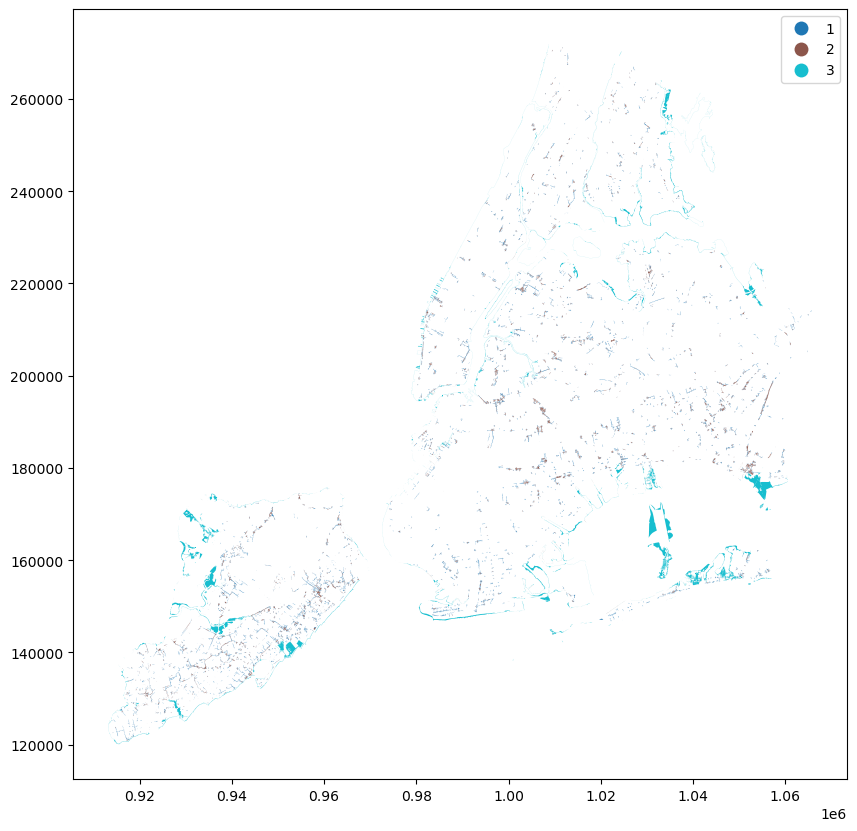

In [7]:
flood_2050.plot('Flooding_Category',
                figsize=(10,10),
                legend=True,
                categorical=True)

For now, let's just use **Category 1 "Nuisance Flooding"** to simplify this calculation. I'm going to create a new gdf called `flood_2020_cat1` 

In [8]:
flood_2050_cat1 = flood_2050[flood_2050['Flooding_Category'] == 1]

## 1.2 `.overlay()`
We'll want to estimate the **percentage of the neighborhood at risk of all categories of flooding**. The first step is to do the following: 
1. Check the CRS between our two layers to make sure they are the same. 
2. Find the **Intersection** of geometries, using the `.overlay()`, function between the neighborhoods and the flood zones: That is we'll want to find the shapes that overlap between the neighborhood and each flood zone. 

In [9]:
nta.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [10]:
flood_2050_cat1.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Looks like they are different: 
- `nta` is **EPSG:4326**
- `flood_2050` is **EPSG:2263**

Notice that EPSG:2263 is in **feet**. Again, whenever we want to estimate areas, volumes, or lengths, we'll want to do this in a CRS in a unit that we can understand. (Areas in degrees doesn't make too much sense.) 

For now, let's convert the `nta` to **EPSG:2263** to have our measurements in **feet**. I'm going to create a new gdf `nta_2223`. 

In [11]:
nta_2263 = nta.to_crs(flood_2050_cat1.crs)

Finally, I want to create this overlay and assign it to a new gdf called `nta_2263_overlay_flood`. Note: This may take little bit of time as the `.overlay()` function is calculating all possible matches. Between geometries in `nta_2263` and `flood_2050_cat1`. (It took about 45 seconds on my computer.)

In [12]:
nta_2263_overlay_flood = gpd.overlay(nta_2263,flood_2050_cat1,how='intersection')

## Q.1 Groupby-and-summarize (5 pts)
How many rows for each neighborhood are there? `nta_2263_overlay_flood`? 

In [13]:
## insert your code here
nta_2263_overlay_flood.groupby("boroname").size()

boroname
Bronx            37
Brooklyn         48
Manhattan        29
Queens           58
Staten Island    19
dtype: int64

Let's take a look at what resulted. We can see here that we have columns from both the neighborhoods and flood gdfs. 

In [14]:
nta_2263_overlay_flood.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,Flooding_Category,Shape_Length,Shape_Area,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((997959.212 163942.904 0.000,..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1000431.742 188044.950 0.000...
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1013268.542 251529.405 0.000...
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,1,7.065402e+06,8.657528e+07,"MULTIPOLYGON Z (((991202.861 163727.372 0.000,..."
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,1,7.065402e+06,8.657528e+07,MULTIPOLYGON Z (((1009305.635 177614.856 0.000...


<AxesSubplot: >

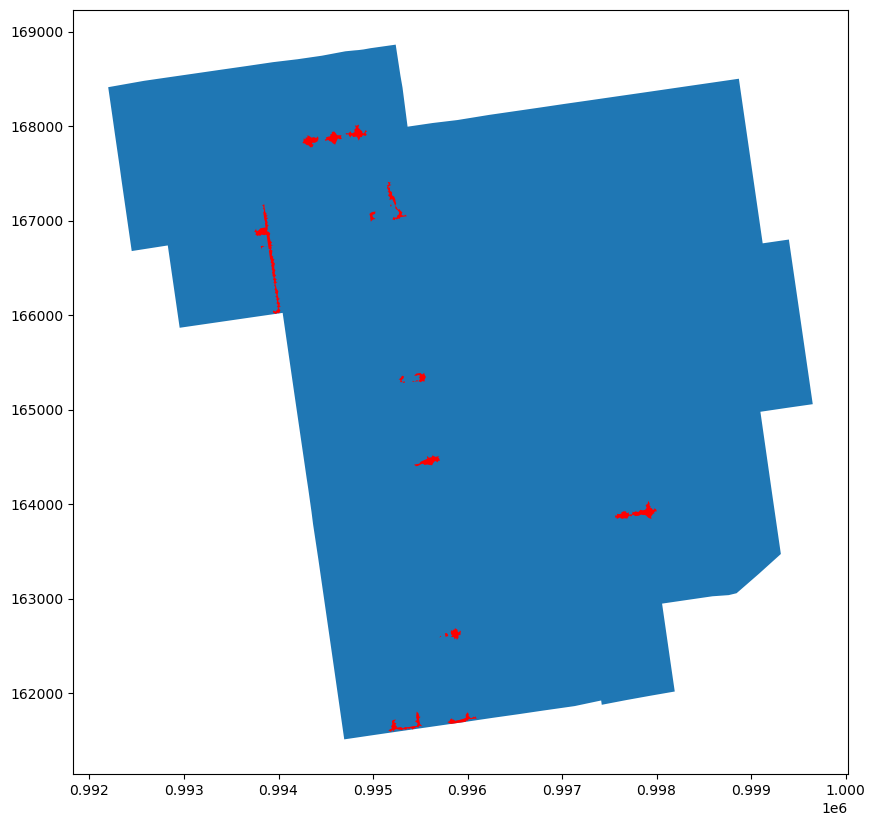

In [15]:
## I'm just going to select one neighborhood and see what this overlay looks like
fig1,ax1 = plt.subplots(1,1,figsize=(10,10))

## Plotting the neighborhood BK43
nta_2263[nta_2263['ntacode']=='BK43'].plot(ax=ax1)

## Plotting the flood zone intersecting with the neighborhood
nta_2263_overlay_flood[nta_2263_overlay_flood['ntacode']=='BK43'].plot(ax=ax1,color='red')

## 1.3 Find area percentage
For all neighborhoods, I'll want to find: 
$$
\% floodzone_{n} =\frac{A_{fn}}{A_{n}}
$$

where $n$ is a neighborhood, $A_{fn}$ is the area of the flood zone that intersects with that neighborhood $n$ and $A_n$ is the area of the neighorhood.

(Yes we can write mathematical notation in Markdown using LaTex! No, I won't make you do it if you aren't already familiar with LaTex.)

To do this, we'll need: 
- $A_{fn}$ 
- $A_n$

In [16]:
nta_2263_overlay_flood['area_flood'] = nta_2263_overlay_flood.area
nta_2263['area_neighb'] = nta_2263.area

## 1.4 Merge
I'm now going merge my `nta_2263_overlay_flood` gdf with the `nta_2263` because I want to divide `area_flood` and `area_neighb`. 
 

In [17]:
## Again I'm just going to select the two columns I need, the neighborhood code (to perform the merge) and the area of the flood zone (to calculate the percentage of the neighborhood that is flooded)
## I'm going to use a left join, so that I keep all the neighborhoods in the original dataset, 
## even if they don't intersect with the flood zone dataset

nta_2263_merged = nta_2263.merge(nta_2263_overlay_flood[['ntacode','area_flood']],on='ntacode',how='left')

Super! 

In [18]:
nta_2263_merged.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,area_neighb,area_flood
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((998870.807 168503.119, 998996.889 16...",3.579964e+07,172189.627708
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((1000351.303 194574.900, 999670.074 1...",3.262983e+07,853010.074002
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((1014295.119 253236.989, 1014383.000 ...",6.307284e+06,13425.316076
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((990897.900 169268.121, 990588.252 16...",5.400502e+07,122640.939602
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((1009623.354 176865.760, 1009376.458 ...",3.270695e+07,582202.028122


## 1.5 Calculate percentage
Lastly, we'll just have to calculate the percentage of the flood zone in each neighborhood. 


In [19]:
nta_2263_merged['perc_flood'] = nta_2263_merged['area_flood']/nta_2263_merged['area_neighb']

<AxesSubplot: >

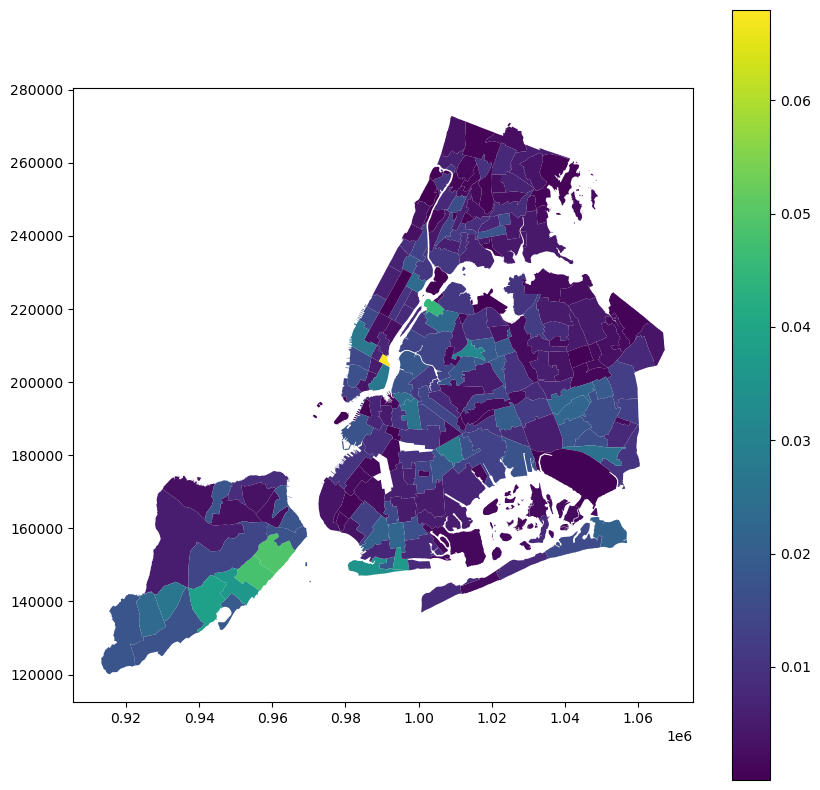

In [20]:
nta_2263_merged.plot(column='perc_flood', 
                        legend=True,
                        figsize=(10,10))

## Q.2 - Topical Knowledge (5 pts)
Here we used flood zone coverage in a neighborhood as proxy for flood. Why might this be an inexact estimate of flood risk? Propose and describe at least three factors we may not have considered in this analysis. 

1. Flood zone coverage doesn't necessarily indicate where it will flood
    - coverage is based on an assumed probability of flood return (i.e., 1/100, 1/500 flood level), these boundaries are arbitrary in the
    sense that more extreme flood events can surpass these boundaries. Additionally, flood risk would also be informed by how frequently it floods in these zones, which is not included in this analysis.
    
2. Flood zone only measures potential area exposure to flooding
    - Risk is defined based on the probability of flooding, as well as who/what is exposed and how vulnerable they are to flooding. 
    This analysis provides a potential area of exposure, but it does not include how many people live in these areas, nor how valuable the buildings and assets are to the city, which also informs how much flood risk is present.

3. Vulnerability is not properly defined
    - Again, while this analysis focuses on exposure, we don't have any information about how populations are vulnerable to damages. Are
    households protected from flooding via structural barriers like seawalls or levees? Do they own flood insurance? These factors would
    influence the amount of flood risk in these areas.

## 1.5 Re-classifying data
Now, instead of using the `perc_flood` column, I want to translate the values in this column into categories that might be more meaningful to a general audience. 

- We might consider binning our values into "Low", "Average", and "High" risk categories. How to determine these? The best approach is have some topical knowledge. For instance, we might read from research reports, look at previous flooding records of these neigbhohoods, etc, to acquire an understanding of how to bin values. 
- A less informed strategy could be to categorize by the distribution of our data. 

We'll take a the less informed strategy here for the sake of time: 

In [21]:
## Remember that the describe function gives us some basic statistics about the data
nta_2263_merged['perc_flood'].describe()

count    191.000000
mean       0.011292
std        0.010102
min        0.000019
25%        0.004067
50%        0.008491
75%        0.016422
max        0.067972
Name: perc_flood, dtype: float64

From the above, we'll use the following criteria: 
- Less than 25th percentile = Low
- 25-75th percentile = Average
- 75th percentile or higher = High

To express this in code. We will: 
- Create a new empty column 
- Filter our gdf based on each criteria
- Assign a different category to each criteria. 

### 1.5.1
First, let's create an empty string column.

In [22]:
# Remember that "" is an empty string
nta_2263_merged['risk_categories'] =""

See that we have a column called `risk_categories` that contains empty strings (note: not the same as `NaN`)

In [23]:
nta_2263_merged.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,area_neighb,area_flood,perc_flood,risk_categories
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((998870.807 168503.119, 998996.889 16...",3.579964e+07,172189.627708,0.004810,
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((1000351.303 194574.900, 999670.074 1...",3.262983e+07,853010.074002,0.026142,
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((1014295.119 253236.989, 1014383.000 ...",6.307284e+06,13425.316076,0.002129,
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((990897.900 169268.121, 990588.252 16...",5.400502e+07,122640.939602,0.002271,
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((1009623.354 176865.760, 1009376.458 ...",3.270695e+07,582202.028122,0.017801,


### 1.5.2 
Now we'll filter for each criteria

In [24]:
## I'm going to use .loc instead of the square bracket method to select the rows and columns I want to edit
## Remember that .loc is used to select rows and columns by label

## So I simultaneously select my filtering criteria for rows and the column I want to edit. 
## 0.004067 is the 25th percentile of the data
nta_2263_merged.loc[nta_2263_merged['perc_flood']<0.004067,'risk_categories'] = 'low'

## A lot of things are happening here: 
## 1. We're filtering for two conditions: Both >=25% and <=75% 
## 2. Because I have multiple conditions, I need to use the & operator to combine them 
## and use the () on each condition
## 3. I'm breaking up my code into multiple lines for readability with the \ character
nta_2263_merged.loc[(nta_2263_merged['perc_flood']>=0.004067)&\
                    (nta_2263_merged['perc_flood']<=0.016422),'risk_categories'] = 'average'

## Always make sure that you're not double counting your rows
## If you use a <=X condition, you'll need to use a >X condition
nta_2263_merged.loc[nta_2263_merged['perc_flood']>0.016422,'risk_categories'] = 'high'

In [25]:
nta_2263_merged.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,area_neighb,area_flood,perc_flood,risk_categories
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((998870.807 168503.119, 998996.889 16...",3.579964e+07,172189.627708,0.004810,average
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((1000351.303 194574.900, 999670.074 1...",3.262983e+07,853010.074002,0.026142,high
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((1014295.119 253236.989, 1014383.000 ...",6.307284e+06,13425.316076,0.002129,low
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((990897.900 169268.121, 990588.252 16...",5.400502e+07,122640.939602,0.002271,low
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((1009623.354 176865.760, 1009376.458 ...",3.270695e+07,582202.028122,0.017801,high


<AxesSubplot: >

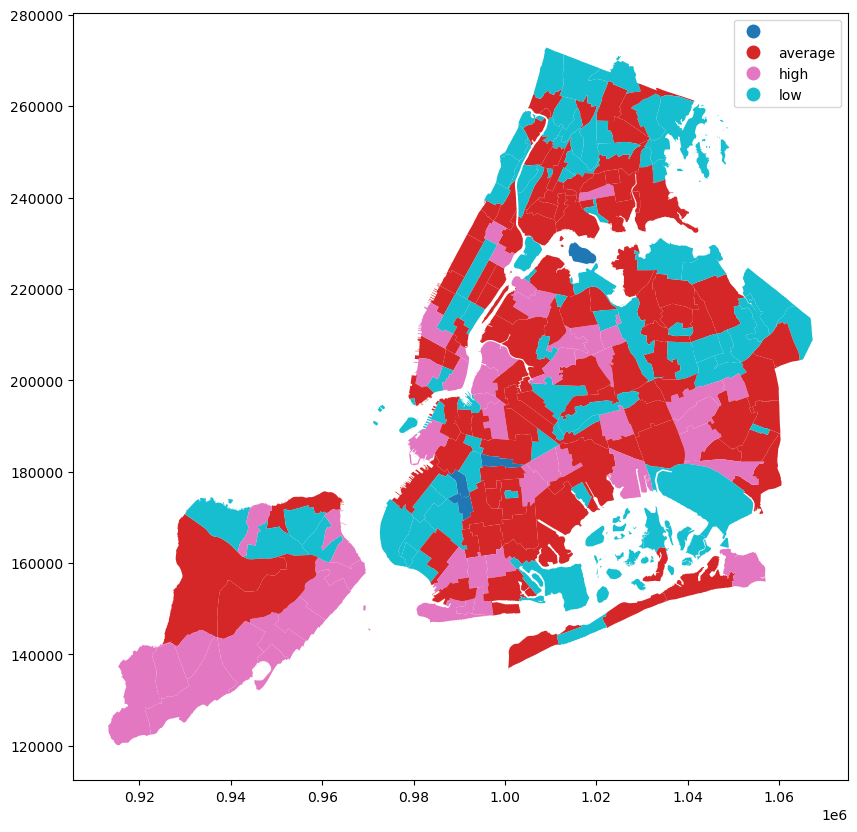

In [26]:
nta_2263_merged.plot(column='risk_categories', 
                        legend=True,
                        categorical=True,
                        figsize=(10,10))

## Q.3 - Missing data (2 pts)
Oops, what happened to those neighborhoods that weren't categorized? 

In [27]:
## insert your code here
nta_2263_merged[nta_2263_merged["risk_categories"] == '']

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,area_neighb,area_flood,perc_flood,risk_categories
14,3.0,Brooklyn,047,BK41,Kensington-Ocean Parkway,1.589335e+07,20800.556075,"POLYGON ((991235.563 174509.977, 991257.634 17...",1.589335e+07,NaN,NaN,
28,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404161e+07,19033.540163,"POLYGON ((989842.548 179997.856, 989842.643 17...",1.404167e+07,NaN,NaN,
30,2.0,Bronx,005,BX98,Rikers Island,1.815460e+07,18903.346271,"POLYGON ((1019454.697 225654.329, 1019451.101 ...",1.815483e+07,NaN,NaN,
131,3.0,Brooklyn,047,BK63,Crown Heights South,1.598989e+07,24192.455655,"POLYGON ((994980.161 183890.329, 995610.371 18...",1.598989e+07,NaN,NaN,


The uncategorized rows are neighborhoods that did not intersect with the flood zone. During the merge process, these rows did not calculate a flooded area, since the flood zone does not encroach into the neighborhood.

## Optional: Q.4 - Classifying Data (5 pts)
How would you recategorize those empty neighborhoods? Map the re-categorized data. 

In [28]:
## insert your code here


## Q.5 (10pts) - Spatial join
- Download the [Points of Interest](https://data.cityofnewyork.us/City-Government/Points-Of-Interest/rxuy-2muj) dataset from the NYC OpenData portal
- Download the [NYCHA Developments](https://data.cityofnewyork.us/Housing-Development/Map-of-NYCHA-Developments/i9rv-hdr5) dataset again. 




For each NYCHA development, calculate the number of POIs within a 15 minute walkshed. Which development has the most POIs within a 15 minute walkshed? Which development has the least? 

### Read in POI shp file

In [29]:
## insert your code here
nyc_poi = gpd.read_file("Points Of Interest/geo_export_82af1862-87bd-41eb-922b-3321f67da211.shp")

nyc_poi.head()

,b7_sc,bin,borough,complexid,date_creat,time_creat,faci_dom,facility_t,date_modif,time_modif,name,placeid,pri_add,saftype,segmentid,sos,source,geometry
0,19743001,0.0,1,0.0,2009-05-14,00:00:00.000,9,6.0,2011-11-18,00:00:00.000,HOLLAND,567.0,0.0,N,31895.0,1,DoITT,POINT (-74.00702 40.72463)
1,49731001,0.0,4,3378.0,2009-05-14,00:00:00.000,8,6.0,2017-01-09,00:00:00.000,WHITESTONE,568.0,0.0,N,306303.0,2,DoITT,POINT (-73.82662 40.79718)
2,39734001,0.0,3,3960.0,2009-05-14,00:00:00.000,8,6.0,2018-01-22,00:00:00.000,BROOKLYN,576.0,0.0,N,144842.0,2,DoITT,POINT (-73.99395 40.70385)
3,19795001,0.0,1,0.0,2009-05-14,00:00:00.000,8,6.0,2011-05-11,00:00:00.000,MANHATTAN,580.0,0.0,N,162664.0,1,DoITT,POINT (-73.99194 40.70960)
4,39740001,0.0,3,0.0,2009-05-14,00:00:00.000,8,6.0,2017-03-03,00:00:00.000,PULASKI,582.0,0.0,N,157362.0,1,DoITT,POINT (-73.95266 40.73907)


### Download and read in  NYCHA Development file again

In [30]:

public_housing = gpd.read_file('Map of NYCHA Developments.zip')

# We are going to filter the data to exclude MultiPolygon objects for this exercise
public_housing = public_housing[public_housing['geometry'].type!='MultiPolygon']

# oops, there's a typo in the column name where "development" is spelled
# "developmen". 
# Let's fix that.
public_housing = public_housing.rename(columns={'developmen':'development'})

public_housing.head()

,borough,development,tds_num,geometry
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-73.88092 40.84050, -73.88068 40.840..."
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-73.94445 40.78071, -73.94456 40.780..."
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((-73.92039 40.66498, -73.92074 40.664..."
3,BRONX,1162-1176 WASHINGTON AVENUE,233,"POLYGON ((-73.90694 40.83009, -73.90705 40.829..."
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((-73.95286 40.80376, -73.95317 40.803..."


In [35]:
#Ensure same CRS
public_housing = public_housing.to_crs(epsg=3857)
nyc_poi = nyc_poi.to_crs(epsg=3857)

#Same crs?
print(nyc_poi.crs == public_housing.crs)



True


### Buffer Public Housing based on 15 min walkshed

Based on a google search, I found that a 15 min minute walk is about 1 mile in distance, or about 1610 meters

In [32]:
#buffer the geometries based on walkshed
ph_buffer = public_housing['geometry'].buffer(1610)
# This the same as the CRS of public housing data 
buffer_crs = public_housing.crs 

# Third, let's grab the data we want
buffer_data = public_housing[['borough', 'development', 'tds_num']]  

# Now, let's put it all together using the GeoDataFrame constructor
public_housing_buffer = gpd.GeoDataFrame(buffer_data, crs=buffer_crs, geometry=ph_buffer)

### Perform a spatial join on the two datasets

In [33]:
#perform spatial join
housing_w_poi = gpd.sjoin(public_housing_buffer,nyc_poi, how = 'left')

In [34]:
#Group by development and use size to count number of rows
housing_walkshed = housing_w_poi.groupby('development').size().sort_values()

#Development with most points
print("Development with most POIs:", housing_walkshed.index[-1],housing_walkshed[-1])
#Development with least points
print("Development with least POIs:", housing_walkshed.index[0],housing_walkshed[0])

Development with most POIs: FIRST HOUSES 634
Development with least POIs: NEW LANE AREA 48
